In [5]:
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import math
import os
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import ListedColormap

In [6]:
# Load data
DF = pd.read_csv("yle_ehdokkaat.csv",skiprows=0)

In [7]:
def clean(x):
    """Parse elements into integers of 1-5. Anomalies are treated as a 0 or 'skip'."""
    if type(x) != float and not x.isdigit():
        return 0
    elif x == float('nan'):
        return 0
    elif math.isnan(float(x)):
        return 0
    else:
        return int(x)
    
# Make `clean` into element-wise function
vclean = np.vectorize(clean)


def filter_blanks(df_region):
    """Return a copy of the input DataFrame without empty rows."""
    temp_mat = vclean(df_region.to_numpy()[:,3:])
    removables_by_index = []
    for i,j in enumerate(temp_mat):
        if np.sum(j) == 0: removables_by_index.append(i)
    removables = [df_region.index[idx] for idx in removables_by_index]
    return df_region.drop(removables)

def to_dict_mat(df_clean_region):
    """Return DataFrame data split into dictionaries and arrays."""
    mat = vclean(df_clean_region.to_numpy()[:,3:])
    ids = list(df_clean_region.index)
    a,b,c = zip(*df_clean_region.to_numpy()[:,:3])
    d = {j:(a[i],b[i],c[i]) for i,j in enumerate(ids)} 
    return ids, d, mat

def general_dict(regions):
    d = {}
    x = np.sum(np.asarray([x.shape[0] for x in regions]))
    ids = []
    mats = []
    for r in regions:
        cand_ids,D,M = to_dict_mat(r)
        mats.append(M)
        ids.append(cand_ids)
        for a,b in D.items():
            d[a] = b 
    return ids,d,np.concatenate(mats)

def clean_data(df):
    l = []
    regions = np.unique(df.vaalipiiri)
    for piiri in np.unique(df.vaalipiiri):
        # print(piiri)
        # 1) Filter out completely Nan rows
        piiri_df = df[df.vaalipiiri == piiri].dropna(axis=1,how='all')

        # 2) Get columns contain only text answers
        removable_cols = list(piiri_df.columns[range(32,82)]) + [col for col in piiri_df.columns if col[-1] == "1"]
        
        # 3) Remove semi-manually 4 questions that were removed afterwards
        removed_questions = ["Energiajuomien myyminen alle", "Nuuskan, purutupakan ja", "On olemassa pyhiä tai muuten", "On oikein nähdä vaivaa sen eteen"]
        
        for que in removed_questions:
            for col in piiri_df.columns:
                if que in col: removable_cols.append(col) 
        
        # 4) Drop those columns and add dataframe to `l` 
        dropped = piiri_df.drop(removable_cols,axis="columns")
        l.append(filter_blanks(dropped))
    
    ids,d,mats = general_dict(l)
    flattened_ids = np.asarray([x for z in ids for x in z])
    m = np.column_stack((flattened_ids,mats))
    return ids,d, m,regions

def Msub(ids,m,reg_idx):
    start = 0
    for i in range(reg_idx): start+= len(ids[i])
    end = start+len(ids[reg_idx])
    return m[start:end]

def get_ids(m):
    return m[:,0].astype(int)

def e(D,cand):
    return 1 if D[cand][2] in [1,2] else 0
    

In [8]:
IDS,D,M,REGIONS = clean_data(DF)
RIDX = list(range(len(IDS)))
M_regs = [Msub(IDS,M,i) for i in RIDX]
N_CANDS = M.shape[0] # 2263
RWEIGHTS = np.asarray([len(x) for x in IDS]) / np.sum(np.asarray([len(x) for x in IDS]))
ELECTED_RATIO = sum([1 for i,c in D.items() if c[2] == 1]) / len(D.items())
PARTIES = np.unique(DF.puolue)
print(REGIONS)

['Ahvenanmaan maakunnan vaalipiiri' 'Helsingin vaalipiiri'
 'Hämeen vaalipiiri' 'Kaakkois-Suomen vaalipiiri'
 'Keski-Suomen vaalipiiri' 'Lapin vaalipiiri' 'Oulun vaalipiiri'
 'Pirkanmaan vaalipiiri' 'Satakunnan vaalipiiri'
 'Savo-Karjalan vaalipiiri' 'Uudenmaan vaalipiiri' 'Vaasan vaalipiiri'
 'Varsinais-Suomen vaalipiiri']


In [9]:
def distance_check(i,j,B):
    return B[i,j]

vdc = np.vectorize(distance_check) # Vectorized element distance look-up for FAST SPEEDS
vdc.excluded.add(2)

def distance(i,j,M, B,norm):
    assert M[i].shape == M[j].shape, "M[i].shape is not M[j].shape"
    skip_filter = np.logical_and(M[i] != 0, M[j] != 0)
    
    
    # Normalizing
    v = vdc(M[i],M[j],B)[skip_filter]
    z = ((np.sum(v**norm))**(1/norm) ) /(v.shape[0])
    if np.isnan(z): print(M[i],M[j])
    return z

In [10]:
B_5 = np.asarray( # 5-point Likert
[[999,   1,   1,   1,   1,  1], 
 [  1,   0, .25,  .5, .75,  1],
 [  1, .25,   0, .25,  .5,.75],
 [  1,  .5, .25,   0, .25, .5],
 [  1, .75,  .5, .25,   0,.25],
 [  1,   1, .75,  .5, .25,  0],
])

B_3 = np.asarray(
[[999,   1,   1,   1,   1,  1],
 [  1,   0,   0,  .5,   1,  1],
 [  1,   0,   0,  .5,   1,  1],
 [  1,  .5,  .5,   0,  .5, .5],
 [  1,   1,   1,  .5,   0,  0],
 [  1,   1,   1,  .5,   0,  0],
])


B_2 = np.asarray( 
[[999,   1,   1,   1,   1,  1],
 [  1,   0,   0,   1,   1,  1],
 [  1,   0,   0,   1,   1,  1],
 [  1,   1,   1,   0,   1,  1],
 [  1,   1,   1,   1,   0,  0],
 [  1,   1,   1,   1,   0,  0],
])

B_dir = np.asarray(
[[999,   1,    1,   1,   1,  1],
 [  1,   0,  .25,  .5, .75,  1],
 [  1, .25, .375,  .5,.625,.75],
 [  1,  .5,   .5,  .5,  .5, .5],
 [  1, .75, .625,  .5,.375,.25],
 [  1,   1,  .75,  .5, .25,  0],
])

B_hyb = np.asarray( 
[[999,   1,    1,   1,    1,  1],
 [  1,   0,  .25,  .5,  .75,  1],
 [  1, .25,.1875,.375,.5625,.75],
 [  1,  .5, .375, .25, .375, .5],
 [  1, .75,.5625,.375,.1875,.25],
 [  1,   1,  .75,  .5,  .25,  0],
])

Bs = [B_5, B_3, B_2, B_dir, B_hyb]

In [11]:
# Given a matrix filled with answers and a distance function (with parameters),
# returns a fully connected weighted graph 

def create_fully_connected(M,B,norm):
    """Return a fully-connected weighted graph (nx.Graph) based on given value matrix M,
    distance matrix A and specific skip_policy string.
    """
    g = nx.Graph()
    edges = []
    for i in range(M.shape[0]):
        for j in range(M.shape[0]): 
            if i != j: edges.append(  (M[i,0],M[j,0], distance(i,j,M[:,1:], B, norm) )   )
    g.add_weighted_edges_from(edges)
    return g

# Outputs a subgraph of G, that contains the MST of G + m-V(MST(G))*p strongest edges
def MST_and_p(g,p):
    """Return a subpgraph of parameter g, that contains the MST of G + m-V(MST(G))*p strongest edges."""
    
    mst = nx.minimum_spanning_tree(g)
    g_edges = sorted(g.edges(data='weight'),key = lambda x: x[2])
    mst_edges = mst.edges(data='weight')
    g_edges_filtered = [e for e in g_edges if e not in mst_edges]    
    mst.add_weighted_edges_from( g_edges_filtered[:int(len(g_edges_filtered)*p)] )

    return mst

def create_graph(M_reg,B,norm,p,graph_name=None):
    """Return a graph for given regional value Matrix M_reg, 
     distance matrix A and specific skip_policy string, and edge-ratio p. 
    """
    
    print(f"Creating graph with {M_reg.shape[0]} nodes and r={p}")
    g = create_fully_connected(M_reg,B,norm)
    g1 = MST_and_p(g,p) if p < 1 else g
    
    if graph_name:
        nx.write_edgelist(g1, f"graphs/{graph_name}.edgelist")
        print(f"Saved {graph_name}.edgelist to /graphs/")
    
    return g1


In [12]:
# Given a graph, calculates the centrality measures for each node and returns them in
# a dict in form {cand_id : (closeness,clustering,betweenness,eignevector) }

def cents_per_node(g,undirected):
    if undirected:
        """Return weighted graph g centrality measures (close,clust,betw,eig) as a dictionary."""
        d_close = nx.closeness_centrality(g) # large weight -> large distance
        d_clust = nx.clustering(g) # large weight -> small distance
        d_betw = nx.betweenness_centrality(g, k=None) # large weight -> large distance
        try:
            d_eig = nx.eigenvector_centrality(g,max_iter=1000) # large weight -> small distance
        except nx.PowerIterationFailedConvergence:
            print("Eigenvectorcentrality failed to converge, replacing with -1's")
            d_eig = {n:-1 for n in g.nodes}
        d_deg = nx.degree_centrality(g)
    else:
        g1 = nx.Graph()
        flipped_edges = [(a,b,{'weight':1/c['weight']}) for a,b,c in g.edges(data=True)] # Uses weights instead of distances
        g1.add_nodes_from(g.nodes)
        g1.add_edges_from(flipped_edges)

        """Return weighted graph g centrality measures (close,clust,betw,eig) as a dictionary."""
        d_close = nx.closeness_centrality(g,distance='weight') # large weight -> large distance
        d_clust = nx.clustering(g1,weight='weight') # large weight -> small distance
        d_betw = nx.betweenness_centrality(g, k=None, weight='weight') # large weight -> large distance
        try:
            d_eig = nx.eigenvector_centrality(g1,max_iter=1000,weight='weight') # large weight -> small distance
        except nx.PowerIterationFailedConvergence:
            print("Eigenvectorcentrality failed to converge, replacing with -1's")
            d_eig = {n:-1 for n in g1.nodes}
        d_deg = nx.degree_centrality(g1)
    return {a:(d_deg[a], d_close[a], d_clust[a], d_betw[a], d_eig[a])  for a,b in d_close.items()}


def cents_per_region(M_regs,B,norm,p,graph_name,undirected):
    """Return within region centrality measures for all regions and candidates."""
    d_cent = {}
    for i,M_reg in enumerate(M_regs):
        name = None if not graph_name else graph_name + "_reg" + str(i)
        g = create_graph(M_reg,B,norm,p,name)
        d_cent = {**d_cent,**cents_per_node(g,undirected)}
    return d_cent


''

In [13]:
g = create_graph(M_regs[0],B_5,1,0.5,graph_name=None)
print(cents_per_node(g,False))
print("\n")
print(cents_per_node(g,True))

Creating graph with 5 nodes and r=0.5
{1070: (1.0, 3.437037037037037, 0.3018330987696151, 0.3333333333333333, 0.5343687441504062), 1071: (0.5, 2.4369747899159666, 0.627729241111516, 0.0, 0.4097193626724866), 1072: (0.75, 2.9237555135475746, 0.4011466315630597, 0.0, 0.4873928766194525), 1073: (0.75, 3.251576734407849, 0.39442311716872486, 0.16666666666666666, 0.4756288029525606), 1074: (0.5, 2.1206581352833638, 0.6075586979285115, 0.0, 0.2877594737778381)}


{1070: (1.0, 1.0, 0.5, 0.3333333333333333, 0.5590326188442775), 1071: (0.5, 0.6666666666666666, 1.0, 0.0, 0.35054183735438676), 1072: (0.75, 0.8, 0.6666666666666666, 0.08333333333333333, 0.46995923844336235), 1073: (0.75, 0.8, 0.6666666666666666, 0.08333333333333333, 0.46995923844336235), 1074: (0.5, 0.6666666666666666, 1.0, 0.0, 0.35054183735438676)}


In [ ]:
import time
# Test a good value for p with B_5 and 1-norm and cents for helsinki region
ps = np.linspace(0,1,21)
results = []
times = []

for p in ps:
    start = time.time()
    degs,closes,clusts,betws,eigs = zip(*cents_per_region([M_regs[1]],Bs[0],1,p,None,True).values())
    end = time.time()
    results.append( [np.mean(degs), np.mean(closes),np.mean(clusts),np.mean(betws),np.mean(eigs),end-start] )

In [ ]:
results_arr = np.asarray(results)
CENTRALITIES = labels = ['degree','closeness','clustering','betweenness','eigenvector']
for i in range(len(results_arr[0])):
    results_arr[:,i] = results_arr[:,i]/np.max(results_arr[:,i])

markers = [".-","o-","v-","s-","+-","x-"]
temp_labels = CENTRALITIES + ["Runtime"]
for i in range(len(results_arr[0])):
    plt.plot(ps,results_arr[:,i],markers[i],label=temp_labels[i])
plt.legend()
plt.axvline(0.2,0,1,linestyle="--")
# plt.title("Average centrality measures for different values of r")
plt.ylabel("Average value normalized by maximum value")
plt.xlabel("Approx. ratio of edges r")
plt.savefig("r_values.png")

In [15]:
P = 0.2
undir= True
B_labels = ["5-point","3-point","Binary","Directional","Hybrid"]
CENTRALITIES = labels = ['degree','closeness','clustering','betweenness','eigenvector']

In [16]:
inp = input("Read/Write/None? (r/w/n)").lower()
dest = f"undir_regionals_r{int(P*10)}.csv" if undir else f"dir_regionals_r{int(P*10)}.csv"
df_columns = ["cand","c_value","centrality","B","norm","elected"]

if inp == "r":
    print(f"DataFrame loaded to df_reg from {dest}")
    df_reg = pd.read_csv(dest,usecols=df_columns)
else:
    
    # Takes quite a while to crunch the 10 regional things
    # A large p makes things a lot slower
    regionals = []
    for i,B in enumerate(Bs):
        print(f"\nCalculating centralities for {B_labels[i]} ({(i+1)}/{len(Bs)})")
        graph_name = f"b{i}"
        regionals.append((i,1,cents_per_region(M_regs,B,1,P,graph_name + "_n1"+f"_r{int(P*10)}", undir)))

    temp_table = []
    for b,n,d_cents in regionals:
        for cand,cents in d_cents.items():
            for ci,c in enumerate(cents):
                temp_table.append( [cand,c,ci,b,n,e(D,cand)] )
    df_reg = pd.DataFrame.from_records(temp_table,columns = df_columns)
    
    if inp == "w":
        df_reg.to_csv(dest,columns = df_columns)
        print(f"Saved to {os.getcwd()}/{dest}")
display(df_reg.head(5))

Read/Write/None? (r/w/n)r
DataFrame loaded to df_reg from undir_regionals_r2.csv


cand   c_value  centrality  B  norm  elected
0  1070  0.750000           0  0     1        1
1  1070  0.800000           1  0     1        1
2  1070  0.333333           2  0     1        1
3  1070  0.666667           3  0     1        1
4  1070  0.603704           4  0     1        1

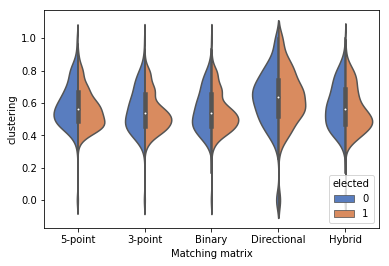

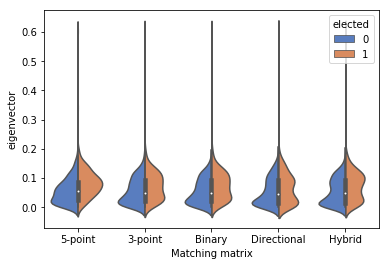

In [17]:
# Regional centrality measures
for i,c in enumerate(CENTRALITIES):
    g = sns.violinplot(x="B", y="c_value", hue="elected",
                       data=df_reg[df_reg.centrality == i][df_reg.norm == 1], palette="muted", split=True,bw=.3)
    plt.ylabel(CENTRALITIES[i])
    plt.xlabel("Matching matrix")
    plt.xticks(np.arange(len(B_labels)), B_labels)
    # save_to f"violins/region_{c}_r{int(P*10)}.pdf" if undir else f"violins/region_{c}_r{int(P*10)}.pdf"
    # plt.savefig(f"violins/region_{c}_r{int(P*10)}.png")
    plt.show()

In [18]:
# Welch's t-test for regions
from scipy import stats

t_table = np.zeros((len(CENTRALITIES),len(B_labels)))
p_table = np.zeros((len(CENTRALITIES),len(B_labels)))

for ridx in range(len(REGIONS)):
    for i,c in enumerate(CENTRALITIES):
        for j,b in enumerate(B_labels):
            df_temp = df_reg[df_reg.centrality == i][df_reg.B == j]
            region_row = [list(REGIONS).index(D[c][0]) for c in df_temp.to_numpy()[:,0]]
            df_temp['ridx'] = region_row
            
            df_elec, df_nelec = df_temp[df_temp.elected == 1][df_temp.ridx == ridx], df_temp[df_temp.elected == 0][df_temp.ridx == ridx]

            t,p = stats.ttest_ind(df_elec.c_value, df_nelec.c_value ,equal_var=False)
            t_table[i,j] = t
            p_table[i,j] = p

    df_reg_ps = pd.DataFrame(p_table,index=CENTRALITIES,columns=B_labels)
    
    display(df_reg_ps)
    save_to = f"welch/undir_regional_welch_r{int(P*10)}_reg{ridx}.csv" if undir else f"welch/dir_regional_welch_r{int(P*10)}_reg{ridx}.csv"
    # df_reg_ps.to_csv(save_to,columns = B_labels)

5-point   3-point    Binary  Directional    Hybrid
degree       0.305899  0.305899  0.305899     0.305899  0.305899
closeness    0.134600  0.134600  0.134600     0.134600  0.134600
clustering   0.278843  0.278843  0.278843     0.278843  0.278843
betweenness  0.090334  0.090334  0.090334     0.090334  0.090334
eigenvector  0.647326  0.647326  0.647326     0.647326  0.647326

5-point   3-point    Binary  Directional    Hybrid
degree       0.000499  0.001912  0.001912     0.013680  0.001030
closeness    0.165255  0.173698  0.173698     0.292249  0.116759
clustering   0.007367  0.009851  0.009851     0.005085  0.007090
betweenness  0.757432  0.617791  0.617791     0.015308  0.752186
eigenvector  0.012238  0.020816  0.020816     0.040176  0.021458

5-point   3-point    Binary  Directional    Hybrid
degree       0.080080  0.264308  0.264308     0.220347  0.098203
closeness    0.248543  0.240832  0.240832     0.087640  0.146672
clustering   0.750703  0.856444  0.856444     0.233994  0.777528
betweenness  0.629400  0.371552  0.371552     0.158348  0.114863
eigenvector  0.208173  0.392822  0.392822     0.606359  0.235911

5-point   3-point    Binary  Directional    Hybrid
degree       0.014153  0.070354  0.070354     0.036111  0.009964
closeness    0.060642  0.158497  0.158497     0.107287  0.059686
clustering   0.320526  0.412948  0.412948     0.675319  0.869987
betweenness  0.508832  0.958296  0.958296     0.112506  0.226402
eigenvector  0.095424  0.201132  0.201132     0.110753  0.051385

5-point   3-point    Binary  Directional    Hybrid
degree       0.062986  0.046576  0.046576     0.180885  0.009161
closeness    0.127848  0.031261  0.031261     0.116279  0.011356
clustering   0.250525  0.873742  0.873742     0.076544  0.446577
betweenness  0.145486  0.948806  0.948806     0.667025  0.230198
eigenvector  0.088765  0.052601  0.052601     0.152559  0.011819

5-point   3-point    Binary  Directional    Hybrid
degree       0.161566  0.105118  0.105118     0.473859  0.233276
closeness    0.054824  0.120537  0.120537     0.360699  0.154739
clustering   0.003023  0.263334  0.263334     0.796844  0.057382
betweenness  0.333388  0.406645  0.406645     0.542284  0.255197
eigenvector  0.503009  0.132664  0.132664     0.297643  0.605183

5-point   3-point    Binary  Directional    Hybrid
degree       0.005566  0.014150  0.014150     0.172436  0.014382
closeness    0.006751  0.005229  0.005229     0.118141  0.002397
clustering   0.362438  0.051206  0.051206     0.426296  0.048044
betweenness  0.193022  0.207243  0.207243     0.452469  0.215364
eigenvector  0.007997  0.133008  0.133008     0.390899  0.180272

5-point   3-point    Binary  Directional    Hybrid
degree       0.000101  0.336691  0.336691     0.517673  0.222002
closeness    0.001811  0.175102  0.175102     0.357348  0.114384
clustering   0.201655  0.878835  0.878835     0.301794  0.315723
betweenness  0.035820  0.757309  0.757309     0.157188  0.975398
eigenvector  0.000425  0.913467  0.913467     0.656381  0.823219

5-point   3-point    Binary  Directional    Hybrid
degree       0.003999  0.025234  0.025234     0.846452  0.089265
closeness    0.002126  0.008811  0.008811     0.659096  0.047224
clustering   0.071947  0.095549  0.095549     0.413498  0.390817
betweenness  0.058457  0.023435  0.023435     0.472943  0.205419
eigenvector  0.004947  0.045830  0.045830     0.697905  0.114342

5-point   3-point    Binary  Directional    Hybrid
degree       0.000421  0.003599  0.003599     0.443494  0.010459
closeness    0.000772  0.007115  0.007115     0.339479  0.003847
clustering   0.055818  0.025742  0.025742     0.710023  0.061456
betweenness  0.059037  0.090588  0.090588     0.141677  0.070843
eigenvector  0.000461  0.002855  0.002855     0.561165  0.014627

5-point   3-point    Binary  Directional    Hybrid
degree       1.391356e-07  0.013128  0.013128     0.297029  0.000899
closeness    3.915267e-06  0.005743  0.005743     0.239054  0.001088
clustering   6.407617e-02  0.873068  0.873068     0.007188  0.522229
betweenness  1.359762e-03  0.887657  0.887657     0.000167  0.106058
eigenvector  8.309341e-05  0.072218  0.072218     0.807190  0.093550

5-point   3-point    Binary  Directional    Hybrid
degree       0.000085  0.044666  0.044666     0.614344  0.047044
closeness    0.000023  0.000085  0.000085     0.174844  0.000103
clustering   0.015284  0.000006  0.000006     0.103506  0.024363
betweenness  0.037860  0.550590  0.550590     0.010049  0.509509
eigenvector  0.000014  0.028667  0.028667     0.205301  0.021412

5-point   3-point    Binary  Directional    Hybrid
degree       0.025314  0.890504  0.890504     0.247679  0.510375
closeness    0.017607  0.734369  0.734369     0.267722  0.652393
clustering   0.321319  0.476111  0.476111     0.765548  0.592538
betweenness  0.223626  0.760146  0.760146     0.792307  0.489820
eigenvector  0.030267  0.482154  0.482154     0.206267  0.770026

In [20]:
# Add region index to df_temp
# CHANGE CENTRALITY TYPE
df_temp = df_reg[df_reg.centrality==1][df_reg.B==0][df_reg.norm==1]
region_row = [list(REGIONS).index(D[c][0]) for c in df_temp.to_numpy()[:,0]]
df_temp['ridx'] = region_row



fig, ax = plt.subplots(figsize=(20,8))

sns.violinplot(x='ridx',y='c_value',data=df_temp,split=True,hue='elected',bw=.3)
region_labels = ['Ahvenanmaa', 'Helsinki', 'Häme', 'Kaakkois-Suomi', 'Keski-Suomi', 'Lappi',
                'Oulu', 'Pirkanmaa', 'Satakunta', 'Savo-Karjala', 'Uusimaa', 'Vaasa', 'Varsinais-Suomi']

plt.xticks(np.arange(0,13),region_labels,rotation=60,size=20)
plt.yticks(size=20)
plt.legend(prop={'size': 20})
# plt.title('Degree centrality distributions between regions',size=20)
plt.xlabel('Election Region',size=20)
plt.ylabel('Closeness Centrality',size=20)
# plt.savefig(f"wide_violin_closeness_r{int(P*10)}.png",bbox_inches='tight')

Text(0, 0.5, 'Closeness Centrality')

In [21]:
# Ahvenanmaa
G=create_graph(M_regs[0],B_5,1,1,graph_name=None)

# G=nx.read_edgelist(path+"b0_n1_reg0.edgelist")
elected_nodes = [n for n in G.nodes() if e(D,int(n))]
pos = nx.kamada_kawai_layout(G)
limits=plt.axis('off')
edge_weights = [5*(1-d['weight'])**5 for u,v,d in G.edges(data=True)]


nx.draw(G,pos,with_labels=False,width=edge_weights,node_color='gray',label="Not elected")

labels = nx.get_edge_attributes(G,'weight')
a,b = zip(*labels.items())
labels = dict(zip(a,[round(1/x,2) for x in b]))



nx.draw_networkx_edge_labels(G,pos,edge_labels=labels)



nx.draw(G,pos,nodelist=elected_nodes,with_labels=False,node_color='gray',node_shape="s",label="Elected")

# plt.title("Election region of Ahvenanmaa",size=15)
plt.legend(["Not elected",None,"Elected"])
# plt.savefig("draw_connected_ahvenanmaa.pdf")

Creating graph with 5 nodes and r=1


In [23]:
M_reg = M_regs[1]
cands = df_reg[df_reg.cand.isin(M_reg[:,0])][df_reg.norm==1][df_reg.centrality==1][df_reg.B==0] # Filter
temp_d = {}

for M_reg in M_regs:
    cands = df_reg[df_reg.cand.isin(M_reg[:,0])][df_reg.norm==1][df_reg.centrality==1][df_reg.B==0] # Filter
    for row in cands.to_numpy():
        key = int(row[0])
        temp_d[key] = tuple(list(D[key]) + [row[1]])
# temp_d

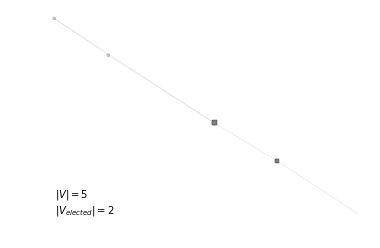

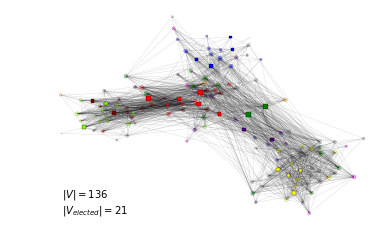

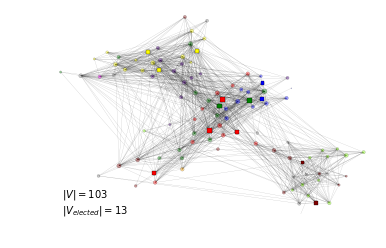

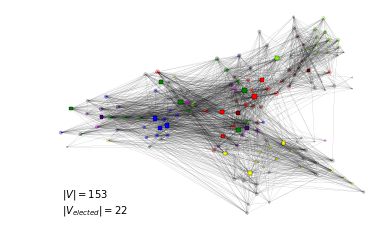

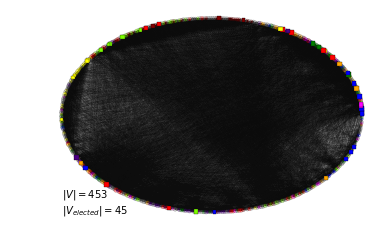

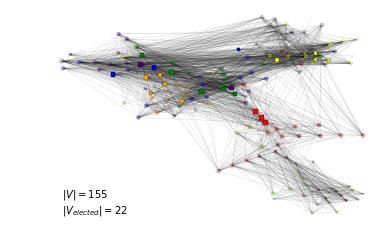

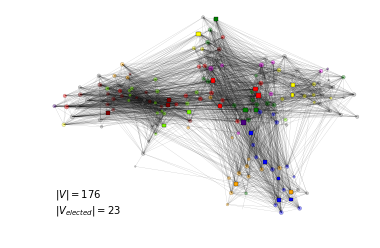

In [25]:
def get_party_colors(nodes):
    d_color = dict(zip(PARTIES,['gray','gray','gray','gray','gray',
            'green','blue', 'gray', 'indigo', 'gray', 'fuchsia',
            'yellow', 'gray', 'orange', 'red',
            'gray','gray', 'gray','gray','gray','maroon','lawngreen']))
    return [d_color[D[n][1]] for n in nodes]

R = 2

for RIDX in range(13):    
    path = "graphs/"
    G=nx.read_edgelist(path+f"b0_n1_r{R}_reg{RIDX}.edgelist")
    f_edges = sorted(G.edges(data=True),key= lambda x: x[2]['weight'])
    f_edges = f_edges[:len(f_edges)//1]

    mst = nx.minimum_spanning_tree(G)
    G = nx.create_empty_copy(G)
    G.add_edges_from(f_edges) # Filter half of edges
    G.add_edges_from(mst.edges(data=True))

    nodes = [int(n) for n in G.nodes()]
    
    pos = nx.kamada_kawai_layout(mst)
    node_labels1 = [e(D,n) for n in nodes]

    edge_weights = [1-e[2]['weight'] for e in G.edges(data=True)]
    edge_weights = [0.15*w**10 for w in edge_weights]
    edge_weights = [w/(2*max(edge_weights)) for w in edge_weights]
    if len(edge_weights) < 100: edge_weights = [w*5 for w in edge_weights]

    nodecolors = get_party_colors(nodes)
    nodesizes = [temp_d[n][3] for n in nodes] # Change between 3 --> 4 (eigenv, closeness)
    nodesizes = [ns-min(nodesizes) for ns in nodesizes]
    nodesizes = [ns/max(nodesizes) for ns in nodesizes]
    nodesizes = [ns*25 for ns in nodesizes]
    nodesizes = [ns for ns in nodesizes]
    
    if undir: edge_weights = 0.15
    a = np.asarray(nodesizes)
    limits=plt.axis('off')

    nx.draw_networkx(G,pos=pos,width=edge_weights,with_labels=False,alpha=0.4,node_size=nodesizes,node_color=nodecolors,linewidths=0.3)
    
    e_nodes = [str(n) for i,n in enumerate(nodes) if e(D,n)]
    e_nodecolors = [n for i,n in enumerate(nodecolors) if e(D,nodes[i])]
    e_nodesizes = [n for i,n in enumerate(nodesizes) if e(D,nodes[i])]
    
    nx.draw_networkx(G,nodelist=e_nodes,pos=pos,width=0,with_labels=False,linewidths=0.3,node_size=e_nodesizes,node_color=e_nodecolors,node_shape="s")
    
    ax = plt.gca() # to get the current axis
    ax.collections[0].set_edgecolor("#000000") 
    ax.collections[2].set_edgecolor("#000000") 
    
    plt.annotate(f'$|V|={len(nodes)}$\n'+"$|V_{elected}|="+f'{len(e_nodes)}$', xy=(0.05, 0.05), xycoords='axes fraction')
    # plt.savefig(f"figures/networks/rainbow{RIDX}_closeness.png",quality=100,dpi=1000,bbox_inches= 'tight',pad_inches=0)
    plt.show()
    
    
    
